In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
calendar = pd.read_csv('../data/calendar.csv')
sales_train_val = pd.read_csv('../data/sales_train_validation.csv')
sales_train_eval = pd.read_csv('../data/sales_train_evaluation.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')

sales_train_val = sales_train_val[sales_train_val['item_id']=='HOBBIES_1_001']
sales_train_eval = sales_train_eval[sales_train_eval['item_id']=='HOBBIES_1_001']

### 01 Preprocessing Data
#### 1.1 Calendar Data

In [3]:
display(calendar.info())
display(calendar.head().T)
display(calendar.describe().T)
display(calendar.isnull().sum().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


None

,0,1,2,3,4
date,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02
wm_yr_wk,11101,11101,11101,11101,11101
weekday,Saturday,Sunday,Monday,Tuesday,Wednesday
wday,1,2,3,4,5
month,1,1,1,2,2
year,2011,2011,2011,2011,2011
d,d_1,d_2,d_3,d_4,d_5
event_name_1,NaN,NaN,NaN,NaN,NaN
event_type_1,NaN,NaN,NaN,NaN,NaN
event_name_2,NaN,NaN,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
wm_yr_wk,1969.0,11347.086338,155.277043,11101.0,11219.0,11337.0,11502.0,11621.0
wday,1969.0,3.997461,2.001141,1.0,2.0,4.0,6.0,7.0
month,1969.0,6.325546,3.416864,1.0,3.0,6.0,9.0,12.0
year,1969.0,2013.288471,1.580198,2011.0,2012.0,2013.0,2015.0,2016.0
snap_CA,1969.0,0.330117,0.470374,0.0,0.0,0.0,1.0,1.0
snap_TX,1969.0,0.330117,0.470374,0.0,0.0,0.0,1.0,1.0
snap_WI,1969.0,0.330117,0.470374,0.0,0.0,0.0,1.0,1.0


date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [4]:
# Convert 'date' column to datetime format
calendar['date'] = pd.to_datetime(calendar['date'])
# drop weekday 
calendar = calendar.drop(columns=['weekday']) 

In [5]:
# define a function to do the following steps for columns: event_name_1, event_type_1, event_name_2, event_type_2
def process_event_column(column, calendardata):
    # Get unique values for the event_name column and the associated date
    temp_df = calendardata[[column, 'date']].dropna().sort_values(by=[column, 'date']).reset_index(drop=True)
    
    # Pivot the data: event names become columns, and dates remain as index
    temp_df = temp_df.pivot(index='date', columns=column, values=column)
    
    # Fill NaN values with 0, and existing values with 1
    temp_df = temp_df.fillna(0).applymap(lambda x: 1 if x != 0 else 0)
    # Merge the resulting pivoted DataFrame back to the original calendar data by date
    calendardata = calendardata.merge(temp_df, on='date', how='left')
    # Drop the original column after merge
    calendardata = calendardata.drop(columns=[column])
    # Return the updated calendar data and the new column names
    return calendardata, temp_df.columns.tolist()


# apply the function to the columns
calendar, event_name_1_columns = process_event_column(column='event_name_1', calendardata=calendar)
calendar, event_type_1_columns = process_event_column(column='event_type_1', calendardata=calendar)
calendar, event_name_2_columns = process_event_column(column='event_name_2', calendardata=calendar)
calendar, event_type_2_columns = process_event_column(column='event_type_2', calendardata=calendar)

# print("event_name_1_columns: ", event_name_1_columns)
# print("event_type_1_columns: ", event_type_1_columns)
# print("event_name_2_columns: ", event_name_2_columns)
# print("event_type_2_columns: ", event_type_2_columns)

#### 1.2 Sell Prices Data
The store and item IDs together with the sales price of the item as a weekly average.

In [6]:
display(sell_prices.info())
display(sell_prices.head())
display(sell_prices.describe().T)
display(sell_prices.isnull().sum().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


None

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


,count,mean,std,min,25%,50%,75%,max
wm_yr_wk,6841121.0,11382.943423,148.610026,11101.00,11247.00,11411.00,11517.00,11621.00
sell_price,6841121.0,4.410952,3.408814,0.01,2.18,3.47,5.84,107.32


store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

#### 1.3 Sales_train_validation

In [7]:
display(sales_train_val.info())
display(sales_train_val.head())
display(sales_train_val.describe().T)
display(sales_train_val.isnull().sum().T)

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 27441
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 150.0+ KB


None

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
3049,HOBBIES_1_001_CA_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,0,0,0,0,...,0,0,1,2,0,4,0,0,2,2
6098,HOBBIES_1_001_CA_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,2,4,0,1,1,1,0,3,3
9147,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,0,0,0,0,...,1,0,0,1,0,1,0,1,2,1
12196,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2


,count,mean,std,min,25%,50%,75%,max
d_1,10.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
d_2,10.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
d_3,10.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
d_4,10.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
d_5,10.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...
d_1909,10.0,0.8,1.229273,0.0,0.00,0.5,1.00,4.0
d_1910,10.0,0.6,0.966092,0.0,0.00,0.0,1.00,3.0
d_1911,10.0,0.3,0.674949,0.0,0.00,0.0,0.00,2.0
d_1912,10.0,0.9,1.100505,0.0,0.00,0.5,1.75,3.0


id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [8]:
# Pivot the dataframe d1 to d1913 to rows
sales_train_val_T = sales_train_val.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    value_vars=sales_train_val.columns[sales_train_val.columns.get_loc('d_1'):sales_train_val.columns.get_loc('d_1913')+1],
    var_name='d',
    value_name='sales'
)
display(sales_train_val_T.head())
display(sales_train_val_T.tail())

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_001_CA_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0
2,HOBBIES_1_001_CA_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0
3,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0
4,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
19125,HOBBIES_1_001_TX_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_2,TX,d_1913,0
19126,HOBBIES_1_001_TX_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_3,TX,d_1913,0
19127,HOBBIES_1_001_WI_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,d_1913,1
19128,HOBBIES_1_001_WI_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_2,WI,d_1913,1
19129,HOBBIES_1_001_WI_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,d_1913,0


#### 1.4 Sales_train_evaluation

In [9]:
display(sales_train_eval.info())
display(sales_train_eval.head())
display(sales_train_eval.describe().T)
display(sales_train_eval.isnull().sum().T)


<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 27441
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 152.2+ KB


None

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
3049,HOBBIES_1_001_CA_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,0,0,0,0,...,2,0,2,0,2,2,0,2,0,1
6098,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,2,6,0,1,0,2,1,0,1,0
9147,HOBBIES_1_001_CA_4_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,0,0,0,0,...,1,0,3,1,1,1,0,1,2,2
12196,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,2,1,0,2,1,0,1


,count,mean,std,min,25%,50%,75%,max
d_1,10.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0
d_2,10.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0
d_3,10.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0
d_4,10.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0
d_5,10.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
d_1937,10.0,1.0,1.154701,0.0,0.00,0.5,2.0,3.0
d_1938,10.0,0.7,1.059350,0.0,0.00,0.0,1.0,3.0
d_1939,10.0,0.8,1.032796,0.0,0.00,0.5,1.0,3.0
d_1940,10.0,0.6,0.843274,0.0,0.00,0.0,1.0,2.0


id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64

In [10]:
# Pivot the dataframe d1 to d1913 to rows
sales_train_eval_T = sales_train_eval.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    value_vars=sales_train_eval.columns[sales_train_eval.columns.get_loc('d_1'):sales_train_eval.columns.get_loc('d_1941')+1],
    var_name='d',
    value_name='sales'
)
display(sales_train_eval_T.head())
display(sales_train_eval_T.tail())

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_001_CA_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0
2,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0
3,HOBBIES_1_001_CA_4_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0
4,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
19405,HOBBIES_1_001_TX_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_2,TX,d_1941,1
19406,HOBBIES_1_001_TX_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_3,TX,d_1941,1
19407,HOBBIES_1_001_WI_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,d_1941,2
19408,HOBBIES_1_001_WI_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_2,WI,d_1941,0
19409,HOBBIES_1_001_WI_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,d_1941,0


#### 1.5 Sales_train_validation and Sales_train_evaluation

In [11]:
print("sales_train_val_T.shape: ", sales_train_val_T.shape)
print("sales_train_eval_T.shape: ", sales_train_eval_T.shape)


sales_train_val_T.shape:  (19130, 8)
sales_train_eval_T.shape:  (19410, 8)


In [12]:
# Concatenate sales_train_val_T and sales_train_eval_T
sales_train = pd.concat([sales_train_val_T, sales_train_eval_T], ignore_index=True)
print("sales_train.shape: ", sales_train.shape)


sales_train.shape:  (38540, 8)


In [13]:
# extract the day number from the 'd' column
sales_train['day'] = sales_train['d'].str.extract('d_(\d+)').astype(int)
display(sales_train.head())
display(sales_train.tail())

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,1
1,HOBBIES_1_001_CA_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0,1
2,HOBBIES_1_001_CA_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,1
3,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0,1
4,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0,1


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day
38535,HOBBIES_1_001_TX_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_2,TX,d_1941,1,1941
38536,HOBBIES_1_001_TX_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_3,TX,d_1941,1,1941
38537,HOBBIES_1_001_WI_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,d_1941,2,1941
38538,HOBBIES_1_001_WI_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_2,WI,d_1941,0,1941
38539,HOBBIES_1_001_WI_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,d_1941,0,1941


#### 1.6 Merge sales_train with Calendar + Sell_prices


In [14]:
# merge sales_train with calendar on 'd' + sell_prices on 'wm_yr_wk'
sales_train2 = sales_train.merge(calendar, on='d').merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'])
# drop the 'd' column
sales_train = sales_train2.drop(columns=['d'])
# calculate daily revenue n 
sales_train['revenue'] = sales_train['sales'] * sales_train['sell_price']
sales_train['']
display(sales_train.head().T)


,0,1,2,3,4
id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001_WI_1_validation,HOBBIES_1_001_CA_1_validation
item_id,HOBBIES_1_001,HOBBIES_1_001,HOBBIES_1_001,HOBBIES_1_001,HOBBIES_1_001
dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1
cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES
store_id,CA_1,CA_4,TX_1,WI_1,CA_1
state_id,CA,CA,TX,WI,CA
sales,0,0,0,0,0
day,897,897,897,897,898
date,2013-07-13 00:00:00,2013-07-13 00:00:00,2013-07-13 00:00:00,2013-07-13 00:00:00,2013-07-14 00:00:00
wm_yr_wk,11325,11325,11325,11325,11325


### 02 EDA + Feature Engineering
#### 2.1 Sales Features
##### 2.1.1 EDA

Text(0.5, 1.0, 'Sales Over the Years')

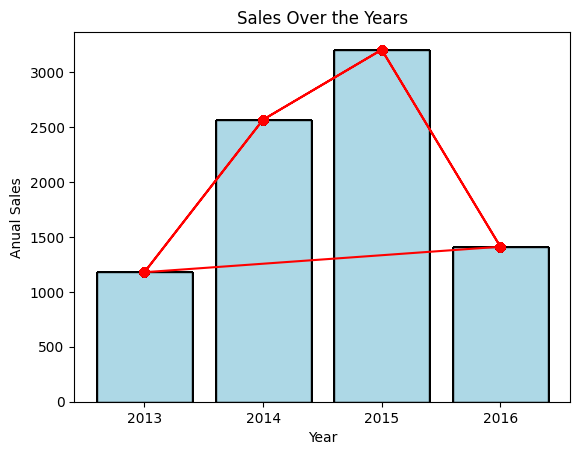

In [26]:


sales_train['annual_sales']= sales_train['sales'].groupby(sales_train['year']).transform('sum')

# # Create the bar plot for sales over the years
plt.bar(sales_train['year'], sales_train['annual_sales'], color='lightblue', edgecolor='black', label='Sales')

# # Overlay a line plot to show the trend
plt.plot(sales_train['year'], sales_train['annual_sales'], color='red', marker='o', label='Trend')

# Set x-ticks to be integers
plt.xticks(sales_train['year'].unique())

# # Add labels and title
plt.xlabel('Year')
plt.ylabel('Anual Sales')
plt.title('Sales Over the Years')

   year  sales
0  2013   1178
1  2014   2566
2  2015   3202
3  2016   1410


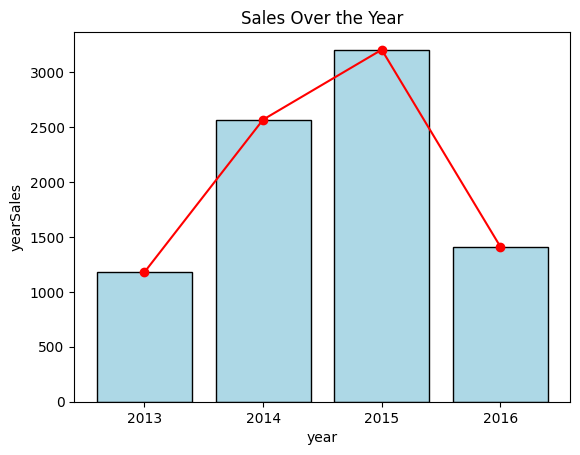

In [40]:
def plot_sales_bytime(period='year'):
    
    temp = sales_train['sales'].groupby(sales_train[period]).sum().reset_index()
    print(temp)

    # Create the bar plot for sales over the years
    plt.bar(temp[period], temp['sales'], color='lightblue', edgecolor='black', label='Sales')

    # Overlay a line plot to show the trend
    plt.plot(temp[period], temp['sales'], color='red', marker='o', label='Trend')

    # # Set x-ticks to be integers
    plt.xticks(temp[period].unique())

    # # # Add labels and title
    plt.xlabel(period)
    plt.ylabel(period+'Sales')
    plt.title('Sales Over the ' + period.capitalize())

plot_sales_bytime(period='year')

    month  sales
0       1    750
1       2    736
2       3    840
3       4    719
4       5    575
5       6    436
6       7    658
7       8    582
8       9    662
9      10    768
10     11    822
11     12    808


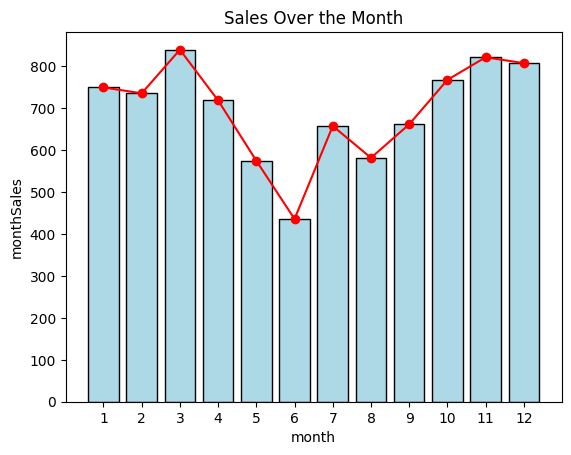

In [41]:
plot_sales_bytime(period='month')

     wm_yr_wk  sales
0       11325     16
1       11326     14
2       11327     34
3       11328     32
4       11329     42
..        ...    ...
145     11613     64
146     11614     33
147     11615     43
148     11616     55
149     11617     15

[150 rows x 2 columns]


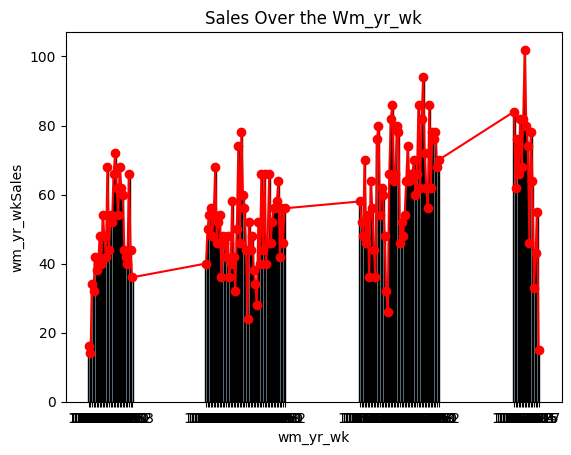

In [44]:
plot_sales_bytime(period='wm_yr_wk')

In [ ]:
sales_trains

   wday  sales
0     1   1418
1     2   1373
2     3   1159
3     4   1149
4     5   1073
5     6    984
6     7   1200


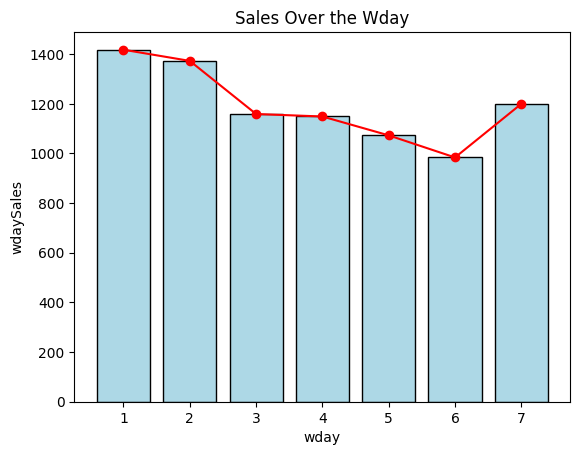

In [43]:
plot_sales_bytime(period='wday')